<a href="https://colab.research.google.com/github/fhrzn/advanced-nlp/blob/main/HW1_Affandy%20Fahrizain_J41332c.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**SOFT DEADLINE:** `20.03.2022 23:59 msk` 

# [5 points] Part 1. Data cleaning

The task is to clear the text data of the crawled web-pages from different sites. 

It is necessary to ensure that the distribution of the 100 most frequent words includes only meaningful words in english language (not particles, conjunctions, prepositions, numbers, tags, symbols).

Determine the order of operations below and carry out the appropriate cleaning.

1. Remove non-english words
1. Remove html-tags (try to do it with regular expression, or play with beautifulsoap library)
1. Apply lemmatization / stemming
1. Remove stop-words
1. Additional processing - At your own initiative, if this helps to obtain a better distribution

#### Hints

1. To do text processing you may use nltk and re libraries
1. and / or any other libraries on your choise

#### Data reading

The dataset for this part can be downloaded here: `https://drive.google.com/file/d/1wLwo83J-ikCCZY2RAoYx8NghaSaQ-lBA/view?usp=sharing`

In [1]:
!pip install -U gensim
!pip install topicnet
!pip install datasketch

     |████████████████████████████████| 24.1 MB 1.5 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
     |████████████████████████████████| 104 kB 8.8 MB/s 
     |████████████████████████████████| 1.9 MB 11.5 MB/s 
     |████████████████████████████████| 137 kB 56.7 MB/s 
     |████████████████████████████████| 136 kB 41.9 MB/s 
  Created wheel for topicnet: filename=topicnet-0.8.0-py3-none-any.whl size=134578 sha256=0d37d0ea15210eb7b09e5fb75454776fff6362acc285779a18446865228f11f1
  Stored in directory: /root/.cache/pip/wheels/f9/13/72/afb22298e81a9a190b608c6f9185ee0f7b0fe0865aed9dae09
  Created wheel for strictyaml: filename=strictyaml-1.6.1-py3-none-any.whl size=123931 sha256=d5fe7e50f1d204e96057c8c1f6e957825a2256c73cd74af18005dea828575324
  Stored in directory: /root/.cache/pip/wheels/3e/7f/3a/d36577e71e78a8e7f89a6a263c03dd39e3f876e74d1ebb051b
Successfully built topicnet str

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
from bs4 import BeautifulSoup
import html
import re
import unicodedata
import spacy
from tqdm.notebook import tqdm
from collections import Counter
import nltk
from nltk.corpus import words
from datasketch import MinHash, MinHashLSH
import plotly.graph_objs as go
from plotly.offline import iplot

In [4]:
nltk.download('words')
nlp = spacy.load('en_core_web_sm')

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


In [ ]:
web_df = pd.read_csv('web_sites_data.csv')
web_df.head()

,text
0,"<html>\n<head profile=""http://www.w3.org/2005/..."
1,"<html>\n<head profile=""http://www.w3.org/2005/..."
2,"<html>\n<head profile=""http://www.w3.org/2005/..."
3,"<html>\n<head profile=""http://www.w3.org/2005/..."
4,"<html>\n<head profile=""http://www.w3.org/2005/..."


#### Data processing

In [ ]:
contents = web_df['text'].to_list()
len(contents)

71699

In [5]:
def clean(text):
    doc = BeautifulSoup(html.unescape(text), 'html.parser').text
    no_extra_enter = re.sub(r'\n+', '\n', doc)
    # fix_unicode = unicodedata.normalize('NFKD', no_extra_enter)    
    no_nonascii = re.sub(r'[^\x00-\x7f]', r'', no_extra_enter)
    pattern1 = r'(?<!\s|\-)([A-Z][a-z]+)'
    pattern2 = r'((\d+\-\d+)([A-z]+))'
    fix_camel_case = re.sub(pattern2, r'\2 \3',\
        re.sub(pattern1, r' \1', no_nonascii))
    no_link = re.sub(r'https?://\S+|www\.\S+', '', fix_camel_case)
    # remove punctuation
    punct = r'[\!\"\#\$\%\&\'\(\)\*\+\,\-\.\/\:\;\<\=\>\?\@\[\\\]\^\_\`\{\|\}\~]'
    no_punct = re.sub(punct, '', no_link)
    # remove numbers
    no_number = re.sub(r'\d+', '', no_punct)
    # remove spaces
    no_spaces = re.sub(r' +', ' ', no_number)

    return no_spaces.strip()


def preprocess(text):
    doc = nlp(text)
    tokens = []

    for token in doc:
        if token.lang_ == 'en'\
        and token.pos_ != 'SPACE'\
        and not token.is_stop: 
            tokens.append(token.lemma_)

    return ' '.join(tokens)


def clean_pipeline(text):
    return preprocess(clean(text))

In [ ]:
for c in tqdm(contents[24709:]):
    processed = clean_pipeline(c)
    with open('processed.txt', 'a') as w:
        w.write(processed + '\n')

100%|██████████| 46990/46990 [4:25:51<00:00,  2.95it/s]   


#### Vizualization

As a visualisation, it is necessary to construct a frequency distribution of words (the 100 most common words), sorted by frequency. 

For visualization purposes we advice you to use plotly, but you are free to choose other libraries

In [ ]:
with open('./processed.txt', 'r', encoding='utf-8') as r:
    data = r.readlines()

len(data)

71699

In [ ]:
counter = Counter()

for text in data:
    counter.update(Counter(text.split()))

top100 = counter.most_common(100)
top100[:5]

[('Xbox', 380000),
 ('Game', 365006),
 ('game', 210174),
 ('Games', 190669),
 ('CNET', 123196)]

In [ ]:
df_top100 = pd.DataFrame(top100, columns=['word', 'freq'])
df_top100.head()

,word,freq
0,Xbox,380000
1,Game,365006
2,game,210174
3,Games,190669
4,CNET,123196


In [ ]:
trace = go.Bar(
    x = df_top100.word,
    y = df_top100.freq,
    opacity=.75,
    
)
layout = go.Layout()
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

#### Provide examples of processed text (some parts)

Is everything all right with the result of cleaning these examples? What kind of information was lost?

In [ ]:
# original scraped data
contents[1024][:1000]

'<!DOCTYPE html>\n\n\n<html onclick="window.numPreClicks=(window.numPreClicks+1)||1;window.lastPreClick=event.target">\n    <head>\n<!-- // --><script language=\'javascript\' type=\'text/javascript\'>\n<!--\n\treq_1_1351067931=new Image();\nreq_1_1351067931.src=\'/__ssobj/ard.png?5802792578353125008_1-1-\'+(664*2034740+571);\n//-->\n<!-- // --></script>\n\n        <!-- Flite - 1.37.15 - pwbflite05 -  - Wed Oct 24 04:38:51 EDT 2012 - command=product.view.book - test_cell= -->\n        <meta charset="utf-8" />\n        <meta http-equiv="X-UA-Compatible" content="IE=edge,chrome=1" />\n        <title>BARNES & NOBLE | Gardening for Birds: How to Help Birds Make the Most of Your Garden by Stephen Moss, HarperCollins UK | Hardcover</title>\n        <meta name="keywords" content=""/>\n    \n        <meta name="description" content="Available in: Hardcover. Featuring seven garden plan illustrations, this guide covers different types of garden - window ledge, balcony, terrace or roof terrace, sm

In [ ]:
# preprocessed data
data[1024][:1000]

'barnes noble gardening bird help bird Garden Stephen Moss Harper Collins UK Hardcover Skip Main Content Sign account Account Settings Wish list Order Status NOOK store Events help Election Read decide Holiday Preview Seasons Best Books save Tony Bennetts New Viva Duets Certified PreOwned nookâ ® Devices start Search product book NOOK Store NOOK Books textbook Movies tv music Kids Books Marketplace Rare Books Newsstand Calendars Home Gifts Toys Games Search million Products shopping Bag item spend free SHIPPING book NOOK Books NOOK Textbooks newsstand teen kid Toys Games Home Gifts DV Ds Music Gift Cards close gardening bird help bird Garden Stephen Moss Gill Tomblin Illustrator add List add list bn Library Favorites Wish list read New Essential list create new Essential List enter list enter invalid character enter valid alpha numeric character Essential list New Essential list add description list Submit Cancel New Wish list create new Wish list enter list enter invalid character en

# [10 points] Part 2. Duplicates detection. LSH

#### Libraries you can use

1. LSH - https://github.com/ekzhu/datasketch
1. LSH - https://github.com/mattilyra/LSH
1. Any other library on your choise

1. Detect duplicated text (duplicates do not imply a complete word-to-word match, but texts that may contain a paraphrase, rearrangement of words, sentences)
1. Make a plot dependency of duplicates on shingle size (with fixed minhash length) `define shingle function`
1. Make a plot dependency of duplicates on minhash length (with fixed shingle size) `num_perm`

In [ ]:
NGRAM = 5
NUM_PERM = 32
THRESHOLD = 0.5
DATA_SIZE = 1500

In [ ]:
def shingle(text, ngram=5):
    return set(text[head:head + ngram] for head in range(0, len(text)))

def LSH(data, ngrams, num_perms, threshold):
    
    # transform text into shingles
    # tqdm.write('Transform data...')
    transformed = [shingle(d, ngrams) for d in tqdm(data, desc='Transform data')]
    
    # create minhash
    # tqdm.write('Creating MinHash...')
    min_hashes = []
    for item in tqdm(transformed, desc='Create MinHash'):
        m = MinHash(num_perms)
        # update minhash values
        for d in item:
            m.update(d.encode('utf-8'))                
        # collect minhash
        min_hashes.append(m)

    # create LSH
    # tqdm.write('Create LSH...')
    lsh = MinHashLSH(threshold, num_perms)
    # insert minhash LSH element
    # tqdm.write('Inserting MinHash to LSH...')
    for i, m in enumerate(tqdm(min_hashes, desc='Insert MinHash')):
        # i -> document id
        # m -> minhash
        lsh.insert(i, m)

    # finding similarity
    # tqdm.write('Find Similarity...')
    doc_sim = []
    for i, hash in enumerate(tqdm(min_hashes, desc='Find Similarity')):
        similar = lsh.query(hash)
        # exclude queried document itself
        if i in similar:
            similar.remove(i)

        # collect similar document id
        doc_sim.extend(similar)
    
    return set(doc_sim)

def plot_dependency(x, y, xlabel, ylabel, title, opacity=.75):
    trace = go.Bar(
        x = x,
        y = y,
        opacity=opacity
    )

    layout = go.Layout()
    fig = go.Figure(data=[trace], layout=layout)
    fig.update_xaxes(title_text=xlabel)
    fig.update_yaxes(title_text=ylabel)
    fig.update_layout(title=title)
    iplot(fig)

In [ ]:
ngrams = [25, 50, 75, 100, 125]

# fixed minhash length
fminhash_result = []
for gram in ngrams:
    result = LSH(data[:DATA_SIZE], gram, 128, THRESHOLD)
    fminhash_result.append(len(result))

plot_dependency(ngrams, fminhash_result, 'Shingle Size', 'Duplicates', 'Dependency of Duplicates on Shingle Size (with fixed minhash length)')

Transform data:   0%|          | 0/1500 [00:00<?, ?it/s]

Create MinHash:   0%|          | 0/1500 [00:00<?, ?it/s]

Insert MinHash:   0%|          | 0/1500 [00:00<?, ?it/s]

Find Similarity:   0%|          | 0/1500 [00:00<?, ?it/s]

Transform data:   0%|          | 0/1500 [00:00<?, ?it/s]

Create MinHash:   0%|          | 0/1500 [00:00<?, ?it/s]

Insert MinHash:   0%|          | 0/1500 [00:00<?, ?it/s]

Find Similarity:   0%|          | 0/1500 [00:00<?, ?it/s]

Transform data:   0%|          | 0/1500 [00:00<?, ?it/s]

Create MinHash:   0%|          | 0/1500 [00:00<?, ?it/s]

Insert MinHash:   0%|          | 0/1500 [00:00<?, ?it/s]

Find Similarity:   0%|          | 0/1500 [00:00<?, ?it/s]

Transform data:   0%|          | 0/1500 [00:00<?, ?it/s]

Create MinHash:   0%|          | 0/1500 [00:00<?, ?it/s]

Insert MinHash:   0%|          | 0/1500 [00:00<?, ?it/s]

Find Similarity:   0%|          | 0/1500 [00:00<?, ?it/s]

Transform data:   0%|          | 0/1500 [00:00<?, ?it/s]

Create MinHash:   0%|          | 0/1500 [00:00<?, ?it/s]

Insert MinHash:   0%|          | 0/1500 [00:00<?, ?it/s]

Find Similarity:   0%|          | 0/1500 [00:00<?, ?it/s]

In [ ]:
num_perms = [64, 128, 256, 512, 1024]

# fixed shingles length
fshingle_result = []
for perms in num_perms:
    result = LSH(data[:DATA_SIZE], 50, perms, THRESHOLD)
    fshingle_result.append(len(result))

plot_dependency(num_perms, fshingle_result, 'MinHash Size', 'Duplicates', 'Dependency of Duplicates on Minhash Length (with fixed shingle size)')

Transform data:   0%|          | 0/1500 [00:00<?, ?it/s]

Create MinHash:   0%|          | 0/1500 [00:00<?, ?it/s]

Insert MinHash:   0%|          | 0/1500 [00:00<?, ?it/s]

Find Similarity:   0%|          | 0/1500 [00:00<?, ?it/s]

Transform data:   0%|          | 0/1500 [00:00<?, ?it/s]

Create MinHash:   0%|          | 0/1500 [00:00<?, ?it/s]

Insert MinHash:   0%|          | 0/1500 [00:00<?, ?it/s]

Find Similarity:   0%|          | 0/1500 [00:00<?, ?it/s]

Transform data:   0%|          | 0/1500 [00:00<?, ?it/s]

Create MinHash:   0%|          | 0/1500 [00:00<?, ?it/s]

Insert MinHash:   0%|          | 0/1500 [00:00<?, ?it/s]

Find Similarity:   0%|          | 0/1500 [00:00<?, ?it/s]

Transform data:   0%|          | 0/1500 [00:00<?, ?it/s]

Create MinHash:   0%|          | 0/1500 [00:00<?, ?it/s]

Insert MinHash:   0%|          | 0/1500 [00:00<?, ?it/s]

Find Similarity:   0%|          | 0/1500 [00:00<?, ?it/s]

Transform data:   0%|          | 0/1500 [00:00<?, ?it/s]

Create MinHash:   0%|          | 0/1500 [00:00<?, ?it/s]

Insert MinHash:   0%|          | 0/1500 [00:00<?, ?it/s]

Find Similarity:   0%|          | 0/1500 [00:00<?, ?it/s]

# [Optional 10 points] Part 3. Topic model

In this part you will learn how to do topic modeling with common tools and assess the resulting quality of the models. 

In [6]:
from sklearn.model_selection import train_test_split
import gensim
from gensim.models import TfidfModel, CoherenceModel
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models import Nmf

In [7]:
topics = pd.read_csv('/content/drive/MyDrive/Advanced NLP/data.csv')
topics.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


The provided data contain chunked stories by Edgar Allan Poe (EAP), Mary Shelley (MWS), and HP Lovecraft (HPL).

The dataset can be downloaded here: `https://drive.google.com/file/d/14tAjAzHr6UmFVFV7ABTyNHBh-dWHAaLH/view?usp=sharing`

In [8]:
topics.author.unique()

array(['EAP', 'HPL', 'MWS'], dtype=object)

#### Preprocess dataset with the functions from the Part 1

In [9]:
tqdm.pandas()
topics['clean'] = topics.text.progress_apply(clean_pipeline)
topics.clean.head()

  0%|          | 0/19579 [00:00<?, ?it/s]

0    process afford means ascertain dimension dunge...
1                          occur fumbling mere mistake
2    left hand gold snuff box caper hill cut manner...
3    lovely spring look Windsor Terrace sixteen fer...
4    find gold superintendent abandon attempt perpl...
Name: clean, dtype: object

#### Quality estimation

Implement the following three quality fuctions: `coherence` (or `tf-idf coherence`), `normalized PMI`, `based on the distributed word representation`(you can use pretrained w2v vectors or some other model). You are free to use any libraries (for instance gensim) and components.

### Topic modeling

Read and preprocess the dataset, divide it into train and test parts `sklearn.model_selection.train_test_split`. Test part will be used in classification part. For simplicity we do not perform cross-validation here, but you should remember about it.

In [10]:
X = topics[['id','clean']]
y = topics.author

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((15663, 2), (3916, 2), (15663,), (3916,))

In [11]:
topic_tokens = [text.split() for text in X_train['clean'].to_list()]
topic_tokens[:1]

[['speak', 'peculiarity', 'hair']]

In [12]:
train_docs = [text.split() for text in X_train['clean'].tolist()]
test_docs = [text.split() for text in X_test['clean'].tolist()]

In [13]:
# id2word = Dictionary(train_docs)
# corpus = [id2word.doc2bow(line) for line in train_docs]
# test_corpus = [dictionary.doc2bow(doc) for doc in test_docs]

# tfidf = TfidfModel(corpus)
# tfidf[corpus[0]]

In [14]:
dictionary = Dictionary(train_docs)
dictionary.filter_extremes(no_below=5, no_above=.85)

In [15]:
tfidf = TfidfModel(dictionary=dictionary)

train_corpus = [dictionary.doc2bow(doc) for doc in train_docs]
test_corpus = [dictionary.doc2bow(doc) for doc in test_docs]

train_tfidf = list(tfidf[train_corpus])
test_tfidf = list(tfidf[test_corpus])

Plot the histogram of resulting tokens counts in the processed datasets.

In [17]:
counter = Counter()

for text in X_train['clean'].tolist():
    counter.update(Counter(text.split()))

top100 = counter.most_common(100)

df_top100 = pd.DataFrame(top100, columns=['word', 'freq'])
df_top100.head()

,word,freq
0,man,880
1,come,716
2,time,683
3,know,671
4,see,664


In [18]:
trace = go.Bar(
    x = df_top100.word,
    y = df_top100.freq,
    opacity=.75,
    
)
layout = go.Layout()
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

#### NMF

Implement topic modeling with NMF (you can use `sklearn.decomposition.NMF`) and print out resulting topics. Try to change hyperparameters to better fit the dataset.

In [19]:
import numpy as np

# find best number topic
num_topics = np.arange(1, 25+1)

coherences_nmf = []
npmis_nmf = []
for num in tqdm(num_topics):
      nmf = Nmf(corpus=train_tfidf, \
            id2word=dictionary,
            num_topics=num,
            random_state=42,
            chunksize=1000)
            
      coherence = CoherenceModel(model=nmf, \
            texts=train_docs, 
            # dictionary=id2word,)
            corpus=train_tfidf)

      npmi = CoherenceModel(model=nmf, \
            texts=train_docs, 
            # dictionary=id2word,
            corpus=train_tfidf,
            coherence='c_npmi')

      coherences_nmf.append(coherence.get_coherence())
      npmis_nmf.append(npmi.get_coherence())

  0%|          | 0/25 [00:00<?, ?it/s]

In [20]:
trace_coherence = go.Scatter(x=num_topics, y=coherences_nmf)
layout = go.Layout()
fig = go.Figure(data=[trace_coherence], layout=layout)
fig.update_layout(title='Coherence Score', yaxis_title='Score', xaxis_title='Num Topics')
iplot(fig)

In [45]:
nmf = Nmf(corpus=train_tfidf, \
          id2word=dictionary,
          num_topics=21,
          random_state=42,
          chunksize=1000)
nmf.show_topics()
# doc_nmf = nmf[corpus]

[(10,
  '0.024*"death" + 0.020*"house" + 0.015*"lie" + 0.013*"happy" + 0.013*"morning" + 0.013*"way" + 0.010*"case" + 0.010*"cold" + 0.008*"memory" + 0.008*"work"'),
 (0,
  '0.052*"little" + 0.015*"question" + 0.013*"half" + 0.008*"open" + 0.008*"arise" + 0.007*"head" + 0.007*"city" + 0.007*"tree" + 0.007*"air" + 0.007*"wall"'),
 (1,
  '0.027*"take" + 0.024*"place" + 0.021*"think" + 0.019*"life" + 0.018*"leave" + 0.014*"light" + 0.013*"like" + 0.010*"sea" + 0.009*"water" + 0.008*"o"'),
 (11,
  '0.039*"appear" + 0.019*"talk" + 0.014*"light" + 0.013*"door" + 0.013*"try" + 0.012*"set" + 0.009*"body" + 0.008*"occur" + 0.005*"end" + 0.005*"hole"'),
 (5,
  '0.064*"word" + 0.035*"year" + 0.013*"far" + 0.009*"speak" + 0.007*"child" + 0.007*"horror" + 0.007*"like" + 0.007*"nature" + 0.006*"believe" + 0.005*"spirit"'),
 (12,
  '0.107*"see" + 0.030*"night" + 0.021*"day" + 0.012*"second" + 0.011*"step" + 0.008*"follow" + 0.008*"small" + 0.006*"grow" + 0.006*"vanish" + 0.006*"approach"'),
 (9,
  '0

In [46]:
print(f'Coherence score: {coherences_nmf[20]}')
print(f'NPMI score: {npmis_nmf[20]}')

Coherence score: 0.310329959624332
NPMI score: -0.14494829185205033


#### LDA

Implement topic modeling with LDA (you can use gensim implementation) and print out resulting topics. Try to change hyperparameters to better fit the dataset.

In [23]:
coherences_lda = []
npmis_lda = []
for num in tqdm(num_topics):
      lda = LdaModel(corpus=train_tfidf, \
            id2word=dictionary,
            num_topics=num,
            random_state=42,
            chunksize=1000,
            passes=10,
            alpha='auto',
            per_word_topics=True)
            
      coherence = CoherenceModel(model=lda, \
            texts=train_docs, 
            # dictionary=id2word,)
            corpus=train_tfidf)

      npmi = CoherenceModel(model=lda, \
            texts=train_docs, 
            # dictionary=id2word,
            corpus=train_tfidf,
            coherence='c_npmi')

      coherences_lda.append(coherence.get_coherence())
      npmis_lda.append(npmi.get_coherence())

  0%|          | 0/25 [00:00<?, ?it/s]

In [24]:
trace_coherence = go.Scatter(x=num_topics, y=coherences_lda)
layout = go.Layout()
fig = go.Figure(data=[trace_coherence], layout=layout)
fig.update_layout(title='Coherence Score', yaxis_title='Score', xaxis_title='Num Topics')
iplot(fig)

In [25]:
lda = LdaModel(corpus=train_tfidf, \
        id2word=dictionary,
        num_topics=14,
        random_state=42,
        chunksize=1000,
        passes=10,
        alpha='auto',
        per_word_topics=True)
lda.show_topics()
# doc_lda = lda[corpus]

[(2,
  '0.021*"admit" + 0.020*"plan" + 0.020*"somewhat" + 0.015*"conceive" + 0.013*"Sir" + 0.012*"brief" + 0.012*"haunt" + 0.011*"echo" + 0.011*"forward" + 0.011*"rich"'),
 (5,
  '0.027*"escape" + 0.019*"mention" + 0.018*"Dupin" + 0.018*"whisper" + 0.016*"pale" + 0.014*"conduct" + 0.014*"son" + 0.012*"conclusion" + 0.012*"guide" + 0.012*"s"'),
 (12,
  '0.018*"opinion" + 0.016*"increase" + 0.016*"fully" + 0.014*"Street" + 0.012*"fine" + 0.011*"inhabitant" + 0.011*"certainly" + 0.011*"start" + 0.011*"shut" + 0.010*"distinguish"'),
 (7,
  '0.019*"finally" + 0.017*"utter" + 0.014*"common" + 0.014*"remove" + 0.013*"left" + 0.011*"courage" + 0.011*"main" + 0.011*"anxiety" + 0.010*"health" + 0.010*"laugh"'),
 (9,
  '0.022*"street" + 0.018*"odd" + 0.015*"occur" + 0.013*"beheld" + 0.013*"Madame" + 0.012*"reality" + 0.012*"occupy" + 0.012*"region" + 0.012*"accompany" + 0.011*"apartment"'),
 (1,
  '0.021*"foot" + 0.015*"secret" + 0.014*"large" + 0.013*"smile" + 0.013*"longer" + 0.012*"attempt" + 

In [26]:
print(f'Coherence score: {coherences_lda[13]}')
print(f'NPMI score: {npmis_lda[13]}')

Coherence score: 0.5154982851421
NPMI score: -0.32526744923164425


Implement topic modeling with ARTM. You may use bigartm library (simple installation for linux: pip install bigartm) or TopicNet framework (`https://github.com/machine-intelligence-laboratory/TopicNet`)

Create artm topic model fit it to the data. Try to change hyperparameters (number of specific and background topics) to better fit the dataset. Play with smoothing and sparsing coefficients (use grid), try to add decorrelator. Print out resulting topics.

In [ ]:
def vowpalize_sequence(sequence):   
    '''reference: https://github.com/machine-intelligence-laboratory/TopicNet/blob/master/topicnet/demos/RTL-Wiki-Preprocessing.ipynb''' 
    word_2_frequency = Counter(sequence)
    del word_2_frequency['']

    vw_string = ''

    for word in word_2_frequency:
        vw_string += word + ":" + str(word_2_frequency[word]) + ' '

    return vw_string

In [ ]:
vw_text = []

for i, t in X_train.iterrows():
    docid = t.id    
    vow = '@lemmatized ' + vowpalize_sequence(t.clean.split())
    vw_str = ' |'.join([docid, vow])
    vw_text.append(vw_str)

vw_text[0]

'id04058 |@lemmatized speak:1 peculiarity:1 hair:1 '

### Using BigARTM Library

#### Numpy CountVectorizer format

In [28]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words='english')
n_wd = np.array(cv.fit_transform(X_train.clean).todense()).T
vocab = cv.get_feature_names_out()

In [29]:
import artm

batch_vectorizer = artm.BatchVectorizer(data_format='bow_n_wd',
                                        n_wd=n_wd,
                                        vocabulary=vocab)

In [30]:
artm_data_path = '/content/drive/MyDrive/Advanced NLP/vw_format.txt'
artm_data_target_batch = '/content/drive/MyDrive/Advanced NLP/bigartm/batch'
artm_data_target_dict = '/content/drive/MyDrive/Advanced NLP/bigartm/dictionary'

#### Vowpal Wabbit format

In [ ]:
with open(artm_data_path, 'w') as w:
    for vw in tqdm(vw_text):
        w.write(vw)
        w.write('\n')

  0%|          | 0/19579 [00:00<?, ?it/s]

In [ ]:
import artm

batch_vec = artm.BatchVectorizer(data_path=artm_data_path,
                                 data_format='vowpal_wabbit',
                                 target_folder=artm_data_target_batch)

#### Init Dictionary and Model

In [32]:
artm_dict = artm.Dictionary()

In [ ]:
artm_dict.gather(data_path=artm_data_target_batch)
# save dictionary
artm_dict.save(dictionary_path=artm_data_target_dict)

In [34]:
artm_dict.gather(data_path='/content/urnuuid660eafa6-b258-11ec-8423-0242ac1c0002')
artm_dict.save(dictionary_path=artm_data_target_dict)

In [35]:
# model init
model = artm.ARTM(num_topics=10, 
                  dictionary=artm_dict, 
                  seed=42,
                  num_document_passes=10)
# metrics
model.scores.add(artm.PerplexityScore(name='PPL', dictionary=artm_dict))
model.scores.add(artm.TopTokensScore(name='TopTokensScore', 
                                     num_tokens=10,
                                     dictionary=artm_dict))
model.scores.add(artm.TopicKernelScore(name='TopicKernelScore', 
                                       class_id='@default_class',
                                       probability_mass_threshold=.3,
                                       dictionary=artm_dict))
# decorrelator
model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorelatorPhi', tau=1.5e+5))

In [36]:
model.initialize(dictionary=artm_dict)
# model fit/learning
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=10)

In [37]:
model.score_tracker['PPL'].value

[15457.84375,
 3363.5087890625,
 2895.940673828125,
 2668.788330078125,
 2547.416748046875,
 2466.543701171875,
 2409.14892578125,
 2364.9541015625,
 2330.216552734375,
 2302.48291015625]

In [38]:
for topic in model.topic_names:
    print(f'{topic}: {model.score_tracker["TopTokensScore"].last_tokens[topic]}')

topic_0: ['thing', 'night', 'eye', 'hand', 'fall', 'dream', 'light', 'wall', 'half', 'room']
topic_1: ['word', 'year', 'man', 'live', 'soon', 'strange', 'child', 'good', 'new', 'soul']
topic_2: ['love', 'body', 'return', 'feel', 'feeling', 'pass', 'home', 'throw', 'dear', 'place']
topic_3: ['tell', 'house', 'door', 'open', 'speak', 'street', 'proceed', 'answer', 'character', 'window']
topic_4: ['death', 'fear', 'mind', 'object', 'thought', 'life', 'hope', 'mean', 'shadow', 'cause']
topic_5: ['say', 'little', 'man', 'let', 'human', 'face', 'person', 'die', 'account', 'old']
topic_6: ['great', 'think', 'time', 'heart', 'eye', 'point', 'shall', 'course', 'attention', 'remember']
topic_7: ['leave', 'hear', 'moment', 'mr', 'come', 'arm', 'sound', 'tear', 'manner', 'reply']
topic_8: ['day', 'friend', 'enter', 'father', 'come', 'mother', 'degree', 'wish', 'grow', 'remain']
topic_9: ['know', 'world', 'sea', 'like', 'city', 'come', 'look', 'land', 'rise', 'earth']


In [50]:
model.score_tracker['TopTokensScore'].coherence

[{'topic_0': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]},
 {'topic_0': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]},
 {'topic_0': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]},
 {'topic_0': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]},
 {'topic_0': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]},
 {'topic_0': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]},
 {'topic_0': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]},
 {'topic_0': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]},
 {'topic_0': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]},
 {'topic_0': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}]

In [49]:
model.score_tracker['TopicKernelScore'].coherence

[{'topic_0': 0.0,
  'topic_1': 0.0,
  'topic_2': 0.0,
  'topic_3': 0.0,
  'topic_4': 0.0,
  'topic_5': 0.0,
  'topic_6': 0.0,
  'topic_7': 0.0,
  'topic_8': 0.0,
  'topic_9': 0.0},
 {'topic_0': 0.0,
  'topic_1': 0.0,
  'topic_2': 0.0,
  'topic_3': 0.0,
  'topic_4': 0.0,
  'topic_5': 0.0,
  'topic_6': 0.0,
  'topic_7': 0.0,
  'topic_8': 0.0,
  'topic_9': 0.0},
 {'topic_0': 0.0,
  'topic_1': 0.0,
  'topic_2': 0.0,
  'topic_3': 0.0,
  'topic_4': 0.0,
  'topic_5': 0.0,
  'topic_6': 0.0,
  'topic_7': 0.0,
  'topic_8': 0.0,
  'topic_9': 0.0},
 {'topic_0': 0.0,
  'topic_1': 0.0,
  'topic_2': 0.0,
  'topic_3': 0.0,
  'topic_4': 0.0,
  'topic_5': 0.0,
  'topic_6': 0.0,
  'topic_7': 0.0,
  'topic_8': 0.0,
  'topic_9': 0.0},
 {'topic_0': 0.0,
  'topic_1': 0.0,
  'topic_2': 0.0,
  'topic_3': 0.0,
  'topic_4': 0.0,
  'topic_5': 0.0,
  'topic_6': 0.0,
  'topic_7': 0.0,
  'topic_8': 0.0,
  'topic_9': 0.0},
 {'topic_0': 0.0,
  'topic_1': 0.0,
  'topic_2': 0.0,
  'topic_3': 0.0,
  'topic_4': 0.0,
  'to

Write a function to convert new documents to topics probabilities vectors.

In [41]:
n_wd_test = np.array(cv.transform(X_test.clean).todense()).T
vocab_test = cv.get_feature_names_out()

In [42]:
# batch test
batch_test = artm.BatchVectorizer(data_format='bow_n_wd',
                                        n_wd=n_wd_test,
                                        vocabulary=vocab_test)

In [43]:
# get new documents topics probabilities
test_matrix = model.transform(batch_vectorizer=batch_test)
test_matrix = test_matrix.T

In [44]:
test_matrix.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
1000,3.235223e-01,1.479471e-01,5.289456e-02,1.875182e-04,0.007657,1.324398e-08,2.498078e-05,0.078194,0.006457,3.831159e-01
1001,1.172736e-08,5.161864e-01,2.425080e-03,2.686523e-01,0.000000,2.090025e-01,9.515514e-13,0.003277,0.000457,0.000000e+00
1002,4.593340e-05,7.580248e-02,2.024789e-08,8.780144e-03,0.116249,5.502245e-01,2.274805e-01,0.000000,0.000000,2.141778e-02
1003,7.658780e-08,0.000000e+00,1.112859e-09,2.474029e-01,0.000648,0.000000e+00,1.984104e-01,0.298418,0.255121,0.000000e+00
1004,4.904749e-01,3.803953e-15,3.655445e-01,4.945542e-09,0.000013,3.231268e-05,2.321788e-07,0.022995,0.120939,4.207714e-07


Calculate the quality scores for each model. Make a barplot to compare the quality.

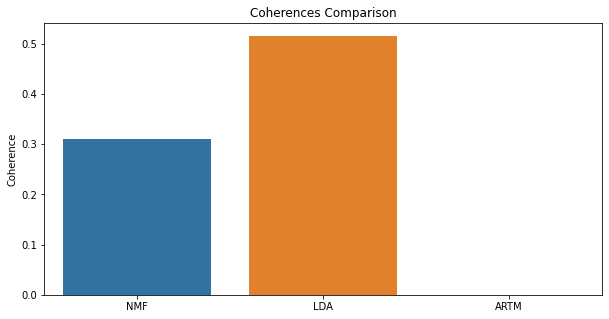

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

labels = ['NMF', 'LDA', 'ARTM']
scores = [coherences_nmf[20], coherences_lda[13], \
          np.mean(model.score_tracker['TopTokensScore'].average_coherence)]

plt.figure(figsize=(10,5))
sns.barplot(y=scores, x=labels)
plt.title('Coherences Comparison')
plt.ylabel('Coherence')
plt.show()

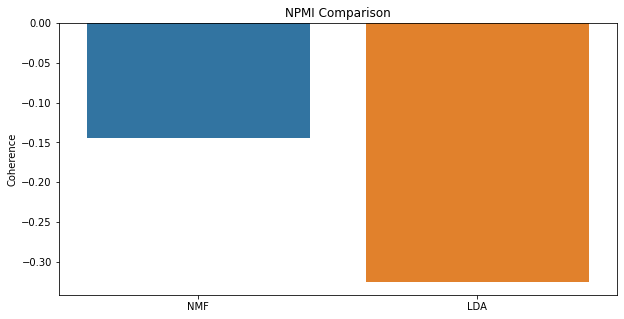

In [58]:
labels = ['NMF', 'LDA']
scores = [npmis_nmf[20], npmis_lda[13]]

plt.figure(figsize=(10,5))
sns.barplot(y=scores, x=labels)
plt.title('NPMI Comparison')
plt.ylabel('Coherence')
plt.show()